In [1]:
import os

# wd = '/mnt/michael/gitrepos/rs_FERNANDO/RFOO'
wd = '/home/romulosmarques/pythonProjects/proteinGeometryData'
wd_pdb = os.path.join(wd, 'pdb')
wd_backbone = os.path.join(wd, 'backbone')
wd_segment = os.path.join(wd, 'segment')
wd_binary = os.path.join(wd, 'binary')

os.chdir(wd)

# !pip install biopandas
# !pip freeze > requirements.txt

from IPython.display import clear_output
clear_output(wait=True)

import pandas as pd
import numpy as np
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Setting up the plot style
sns.set(style="whitegrid")

In [3]:
import json
import requests

# URL of the file to download
fn = 'pdb_entry_type.txt'
url = "https://files.wwpdb.org/pub/pdb/derived_data/" + fn
response = requests.get(url)
if response.status_code == 200:
    with open(os.path.join(wd,fn), 'wb') as fd:
        fd.write(response.content)
else:
    raise Exception(f'Failed to download {url}: {response.status_code}')

!head -n 5 pdb_entry_type.txt

100d	nuc	diffraction
101d	nuc	diffraction
101m	prot	diffraction
102d	nuc	diffraction
102l	prot	diffraction


In [6]:
# convert from txt to pandas
import pandas as pd

# Read the file into a pandas DataFrame
# Assuming the file is tab-delimited and has no header row
df = pd.read_csv(os.path.join(wd,fn), delimiter='\t', header=None)

# Optionally, name the columns
df.columns = ['Protein_ID', 'Type', 'Method']

# Filter Type='prot' and Method='NMR'
df = df[(df['Type'] == 'prot') & (df['Method'] == 'NMR')].copy()

df['Count'] = 1
df_total = df[['Type','Method','Count']].groupby(['Type','Method']).sum().reset_index()
df_total = df_total[['Method','Count']].copy()
df_total

# Export the df_total DataFrame to LaTeX
with open(os.path.join(wd,'df_total.tex'), 'w') as tf:
    tf.write(df_total.to_latex(index=False))

# Export the df DataFrame to LaTeX
df.to_csv(os.path.join(wd,'pdb_entry_prot_NMR.csv'), index=False)

In [8]:
# Download PDB files

import os
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor


# Read the selected_protein_ids.csv file
selected_protein_ids = pd.read_csv(os.path.join(wd,'pdb_entry_prot_NMR.csv'))
selected_protein_ids = selected_protein_ids['Protein_ID'].tolist()

# Get the number of available CPU cores
num_cores = os.cpu_count()

# Set the number of threads to be one less than the number of cores
num_threads = num_cores - 1

# Create a directory to store the downloaded PDB files
os.makedirs(wd_pdb, exist_ok=True)

# Function to download a PDB file
def download_pdb(protein_id):
    file_path = os.path.join(wd_pdb, f'{protein_id}.pdb')

    # Check if the file already exists
    if os.path.exists(file_path):
        print(f"{protein_id}.pdb already exists. Skipping download.")
        return

    url = f'http://files.rcsb.org/download/{protein_id}.pdb'
    response = requests.get(url)

    if response.status_code == 200:
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f"Successfully downloaded {protein_id}.pdb")
    else:
        print(f"Failed to download {protein_id}.pdb")

# Download PDB files for the selected Protein_IDs in parallel
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    executor.map(download_pdb, selected_protein_ids)

# clear_output()

# pdb_files = [fn for fn in os.listdir(wd_pdb)]
# len(pdb_files)

Successfully downloaded 1b4q.pdbSuccessfully downloaded 1b4r.pdb
Successfully downloaded 1b50.pdb
Successfully downloaded 1b53.pdb
Successfully downloaded 1b5a.pdb
Successfully downloaded 1b5n.pdb
Successfully downloaded 1b5b.pdb
Successfully downloaded 1b64.pdb
Successfully downloaded 1b75.pdb
Successfully downloaded 1b6f.pdb
Successfully downloaded 1b8q.pdb
Successfully downloaded 1b9g.pdb
Successfully downloaded 1b8t.pdb
Successfully downloaded 1b8w.pdb
Successfully downloaded 1b9p.pdb
Successfully downloaded 1b9q.pdb
Successfully downloaded 1b9u.pdb
Successfully downloaded 1ba4.pdb
Successfully downloaded 1ba5.pdb
Successfully downloaded 1b9r.pdb
Successfully downloaded 1ba6.pdb
Successfully downloaded 1bah.pdb
Successfully downloaded 1bak.pdb
Successfully downloaded 1ba9.pdb
Successfully downloaded 1bax.pdb
Successfully downloaded 1bba.pdb
Successfully downloaded 1bal.pdb
Successfully downloaded 1bbg.pdb
Successfully downloaded 1bb8.pdb
Successfully downloaded 1bbi.pdb
Successfull

Successfully downloaded 8cjt.pdb


In [56]:
from concurrent.futures import ThreadPoolExecutor
import os
import biopandas.pdb as bp
from tqdm import tqdm

def detect_invalid_residue(df_row):
    residue_name = df_row[1]

    if residue_name in ['PRO', 'GLY']:
        return False

    atoms = df_row[2].split(' ')
    if "N" not in atoms:
        return False
    
    if "CA" not in atoms:
        return False
    
    if "C" not in atoms:
        return False
    
    if "H" not in atoms and "H1" not in atoms:
        return False
    
    if "HA" not in atoms:
        return False
    
    return True

def process_pdb_file(fn):
    # Define the PDB file path
    pdb_id = fn.split('.')[0]
    pdb_fn = os.path.join(wd, 'pdb', fn)

    # Load PDB file
    ppdb = bp.PandasPdb().read_pdb(pdb_fn)

    # Get model indices
    df_MODEL = ppdb.get_model_start_end().copy()

    ATOM = ['C','CA','N','H','H1','HA','HA1']
    COLUMNS = [
        'atom_number',
        'atom_name',
        'residue_name',
        'chain_id',
        'residue_number',
        'x_coord',
        'y_coord',
        'z_coord',
        'b_factor',
        'segment_id',
        'element_symbol',
        'model_id'
    ]
    for _, row in df_MODEL.iterrows():
        model_idx = int(row.model_idx)
        model = ppdb.get_model(model_index=model_idx).df['ATOM']
        # Get only C, CA, N
        model = model[model['atom_name'].isin(ATOM)]
        chains = sorted(list(set(model['chain_id'])))
        if len(chains) > 0:
            chain = chains[0] # only one chain 
            df = model[model['chain_id'] == chain]                                                                                                                                                                                                                                                              .copy()

            # removing invalid residues
            col_residue_atoms = df.groupby(['residue_number']).agg({'residue_name': 'min', 'atom_name': lambda x : ' '.join(x)}).reset_index()
            col_residue_atoms['is_valid'] = col_residue_atoms.apply(detect_invalid_residue, axis=1)
            
            valid_residues = col_residue_atoms[col_residue_atoms['is_valid']]['residue_number']
            valid_residues = set(valid_residues)

            df = df[df['residue_number'].isin(valid_residues)]
            
            fn = os.path.join(wd_backbone, f'{pdb_id}_model{model_idx}_chain{chain}.csv')
            df.to_csv(fn, index=False)
            break  


# df_count_res_atoms = df.value_counts("residue_number", sort=False).reset_index()
# col_count = []
# for _, row in df_count_res_atoms.iterrows():
#     n_atoms = int(row[1])
#     if n_atoms < 5:
#         for i in range(n_atoms):Pö
#             col_count.append(False)
#     else:
#         for i in range(n_atoms):
#             col_count.append(True)

# Set up working directories
wd_pdb = os.path.join(wd, 'pdb')
wd_backbone = os.path.join(wd, 'backbone')

# Create output directory
os.makedirs(wd_backbone, exist_ok=True)

# Get list of PDB files
pdb_files = sorted(os.listdir(wd_pdb))

# Number of threads (adjust as needed)
num_threads = os.cpu_count() - 1

# for fn in tqdm(pdb_files):
#     process_pdb_file(fn)

#part_pdb_files = pdb_files[8291:len(pdb_files)].copy() #list(range(8291, len(pdb_files)))
# Parallel processing
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    list(tqdm(executor.map(process_pdb_file, pdb_files), total=len(pdb_files)))

clear_output()

/tmp/ipykernel_1564/1071099752.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  residue_name = df_row[1]
/tmp/ipykernel_1564/1071099752.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  residue_name = df_row[1]
/tmp/ipykernel_1564/1071099752.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atoms = df_row[2].split(' ')
/tmp/ipykernel_1564/1071099752.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprec

In [14]:
# Create segments
import numpy as np
import pandas as pd
from tqdm import tqdm

wd_segment = os.path.join(wd, 'segment')

# Create output directory
os.makedirs(wd_segment, exist_ok=True)

cols = [
    'residue_number',
    'residue_name',
    'atom_number',
    'atom_name',
    'chain_id',
    'x_coord',
    'y_coord',
    'z_coord'
]

for fn in tqdm(os.listdir(wd_backbone)):
    df = pd.read_csv(os.path.join(wd_backbone, fn))
    df = df[cols]

    # Assume df is your original DataFrame
    df_residue = df.groupby(['residue_number']).max().reset_index()

    # Convert the 'residue_number' column to a NumPy array
    residue_number = df_residue['residue_number'].to_numpy()

    # # Selecting the indices of the proline and glycine residues
    # pro_gly_indices = df_residue[(df_residue['residue_name'] == 'PRO') | (df_residue['residue_name'] == 'GLY')].index.to_numpy()
    # print(pro_gly_indices)

    # Calculate the difference between consecutive entries in the residue_number array
    diffs = np.diff(residue_number)

    # Identify indices where the difference is larger than 1
    split_indices = np.where(diffs > 1)[0] + 1
    # print(split_indices)

    # # Combining the indices of non-consective residues with proline and glycine residues
    # if not split_indices.any():
    #     split_indices = pro_gly_indices
    # elif pro_gly_indices != []:
    #     split_indices = sorted(split_indices + pro_gly_indices)
    
    # Split the array at these indices
    split_arrays = np.split(residue_number, split_indices)

    # Keeping segments which has at least 3 residues.
    cleaned_split_arrays = []
    for index, array in enumerate(split_arrays):
        if len(array) > 3:
            cleaned_split_arrays.append(split_arrays[index])
    
    fn = fn.replace('.csv','')
    for k, residue_numbers in enumerate(cleaned_split_arrays):
        df_segment = df[df['residue_number'].isin(residue_numbers)]

        # Removing the amina hydrogen from the first residue
        row_firstH = df_segment.loc[(df_segment['residue_number'] == residue_numbers[0]) & ((df_segment['atom_name'] == 'H') | (df_segment['atom_name'] == 'H1'))]
        df_segment = df_segment.drop(row_firstH.index)
        
        fn_segment = os.path.join(wd_segment, f'{fn}_segment{k}.csv')
        df_segment.to_csv(fn_segment, index=False)

  0%|          | 0/5481 [00:00<?, ?it/s]

100%|██████████| 5481/5481 [07:18<00:00, 12.50it/s]


In [64]:
# create binary strings
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.spatial import distance

wd_segment = os.path.join(wd, 'segment')

def point_plane_distance(point, plane_points):
    """
    Calculate the signed distance from a point to a plane defined by three points.
    Parameters:
        point (numpy array): The point [x, y, z] we want to check.
        plane_points (numpy array): 3x3 array where each row is a point [x, y, z] defining the plane.
    Returns:
        float: The signed distance from the point to the plane.
    """
    # Calculate the normal vector of the plane
    normal_vector = np.cross(plane_points[1] - plane_points[0], plane_points[2] - plane_points[0])
    
    norm_nv = np.linalg.norm(normal_vector)
    
    if norm_nv == 0:
        raise Exception("Normal vector is null!")

    # Calculate the signed distance
    signed_distance = np.dot(normal_vector, point - plane_points[0]) / norm_nv
    
    return signed_distance


def construct_ddgp_order_1(df):
    """
    Constructs the following ddgp order: N^1, CA^1, HA^1, ..., C^{i-1}, H^i, N^i, CA^i, HA^i, ..., C^n, where n is the number of vertices of the ddgp graph.
    Parameters:
        df (DataFrame): DataFrame containing the 'x' column with 3D coordinates.
    Returns:
        order_1 (numpy array): nx4 array containing:
            (a) in the first column, the DataFrame indices of the elements of the proposed 3-DDGP order_1; 
            (b) in the other three columns, the neigbours which are utilized to emerge the vertices in the R^3;
                order_1[i][1] is closer to order_1[i][0] in the order than order_1[i][2] is, and so on.    
    """

    # df['myind'] = [str(i) for i in range(len(df))]
    df = df.reset_index()
    df['myindex'] = df['index'].apply(lambda x : str(x))
    df_residue_info = df.groupby(['residue_number']).agg({'residue_name': 'min', 'atom_name': lambda x : ' '.join(x), 'myindex': lambda y : ' '.join(y)}).reset_index()
    df = df.drop(['myindex'], axis=1)

    # atom_names_im1 = df_residue_info.iloc[0][2].split(' ')
    atom_names_im1 = df_residue_info.iloc[0].iloc[2].split(' ')
    # atom_indexes_im1 = [int(atom_index) for atom_index in df_residue_info.iloc[0][3].split(' ')]
    atom_indexes_im1 = [int(atom_index) for atom_index in df_residue_info.iloc[0].iloc[3].split(' ')]
    atoms_im1 = {atom_names_im1[k]: atom_indexes_im1[k] for k in range(len(atom_names_im1))}

    # Creating the order_1
    order_1 = np.zeros((len(df), 4))

    # The first three elements of the order
    order_1[0][0] = atoms_im1['N']
    order_1[1][0] = atoms_im1['CA']
    order_1[2][0] = atoms_im1['HA']

    # The first three elements of the order are not calculated using previous neighbours.
    order_1[0][1] = np.nan
    order_1[1][1] = np.nan
    order_1[2][1] = np.nan
    order_1[0][2] = np.nan
    order_1[1][2] = np.nan
    order_1[2][2] = np.nan
    order_1[0][3] = np.nan
    order_1[1][3] = np.nan
    order_1[2][3] = np.nan

    current_i = 3
    for ind, row in df_residue_info.iloc[1:].iterrows():
        #atom_names_i = row[2].split(' ')
        atom_names_i = row.iloc[2].split(' ')
        # atom_indexes_i = [int(atom_index) for atom_index in row[3].split(' ')]
        atom_indexes_i = [int(atom_index) for atom_index in row.iloc[3].split(' ')]
        atoms_i = {atom_names_i[k]: atom_indexes_i[k] for k in range(len(atom_names_i))}

        ################################
        
        if 'C' in atoms_im1:
            order_1[current_i][0] = atoms_im1['C']
        else:
            raise Exception("Atom 'C' does not exist in the %d-th residue!" % ind-1)

        order_1[current_i][1] = atoms_im1['N']
        order_1[current_i][2] = atoms_im1['CA']
        order_1[current_i][3] = atoms_im1['HA']

        ################################

        if 'H' in atoms_i:
            order_1[current_i + 1][0] = atoms_i['H']
        else:
            raise Exception("Atom 'H' does not exist in the %d-th residue!" % ind)

        order_1[current_i + 1][1] = atoms_im1['CA']
        order_1[current_i + 1][2] = atoms_im1['C']
        order_1[current_i + 1][3] = atoms_im1['HA']

        ################################

        if 'N' in atoms_i:
            order_1[current_i + 2][0] = atoms_i['N']
        else:
            raise Exception("Atom 'N' does not exist in the %d-th residue!" % ind)

        order_1[current_i + 2][1] = atoms_im1['CA']
        order_1[current_i + 2][2] = atoms_im1['C']
        order_1[current_i + 2][3] = atoms_i['H']

        ################################

        if 'CA' in atoms_i:
            order_1[current_i + 3][0] = atoms_i['CA']
        else:
            raise Exception("Atom 'CA' does not exist in the %d-th residue!" % ind)

        order_1[current_i + 3][1] = atoms_im1['C']
        order_1[current_i + 3][2] = atoms_i['N']
        order_1[current_i + 3][3] = atoms_i['H']

        ################################

        if 'HA' in atoms_i:
            order_1[current_i + 4][0] = atoms_i['HA']
        else:
            raise Exception("Atom 'HA' does not exist in the %d-th residue!" % ind)

        order_1[current_i + 4][1] = atoms_i['N']
        order_1[current_i + 4][2] = atoms_i['CA']
        order_1[current_i + 4][3] = atoms_i['H']

        ################################

        atom_names_im1 = atom_names_i.copy()
        atom_indexes_im1 = atom_indexes_i.copy()
        atoms_im1 = atoms_i.copy()
        
        current_i = current_i + 5
    
    # The last element of the order
    if 'C' in atoms_i:
        order_1[current_i][0] = atoms_im1['C']
    else:
        raise Exception("Atom 'C' does not exist in the %d-th residue!" % ind)
    
    # The neighbours of the last element
    order_1[current_i][1] = atoms_i['N']
    order_1[current_i][2] = atoms_i['CA']
    order_1[current_i][3] = atoms_i['HA']

    return order_1


def calculate_b_column(df, order=[]):
    """
    Calculate the binary column 'b' based on the 'x' column of the DataFrame.
    Parameters:
        df (DataFrame): DataFrame containing the 'x' column with 3D coordinates.
        order (numpy array): nx4 array containing:
            (a) in the first column, the DataFrame indices of the elements of the proposed 3-DDGP order_1; 
            (b) in the other three columns, the neigbours which are utilized to emerge the vertices in the R^3;
                order_1[i][1] is closer to order_1[i][0] in the order than order_1[i][2] is, and so on.
    Returns:
        Series: Pandas Series containing the binary values for the 'b' column.
    """

    # When no order is passed, we assume the DataFrame order is a 3-DMDGP order
    if len(order) == 0:
        col0 = list(range(len(df)))
        col1 = list(range(-3, len(df)-3))
        col2 = list(range(-2, len(df)-2))
        col3 = list(range(-1, len(df)-1))
        col1[0:3] = [np.nan, np.nan, np.nan]
        col2[0:3] = [np.nan, np.nan, np.nan]
        col3[0:3] = [np.nan, np.nan, np.nan]
        order = np.array([col0, col1, col2, col3,])
        order = np.transpose(order)

    b_values = []
    for i in range(len(df)):
        if i < 3:
            # Not enough points to define a plane
            b_values.append(None)
            continue
        plane_points = np.array(df.iloc[order[i][1:4]]['x'].tolist())
        current_point = df.iloc[i]['x']
        distance_to_plane = point_plane_distance(current_point, plane_points)
        b_values.append(int(distance_to_plane >= 0))
    return pd.Series(b_values)


def flip_b_column_if_needed(b_col):
    """
    Flip the binary column 'b' if the 4th element (index 3) is 1.
    Parameters:
        b_col (Series): Panda Series containing the 'b' column.
    Returns:
        Series: Pandas Series containing the binary values for the 'b' column flipped around the fourth position.
    """
    if len(b_col) > 3 and b_col.iloc[3] == 1:
        # b_col = [1 - x if x is not None else None for x in b_col]
        b_col = b_col.apply(lambda x: 1 - x if x is not None else None)
    return b_col


def write_binary(fn_binary, df, order, b_col):
    df_binary = df[['residue_number', 'atom_name']].copy()
    indices = np.zeros([order.shape[0], 1])
    for i in range(order.shape[0]):
        indices[int(order[i][0])] = i
    df_binary['order'] = indices
    df_binary.sort_values(by=['order'], inplace=True)
    df_binary.drop("order", axis='columns', inplace=True)

    # Guarantees that new columns will not be sorted
    df_binary.reset_index(inplace=True)
    df_binary.rename(columns={'index': 'order'}, inplace=True)

    df_binary['N_1'] = np.concatenate((np.array([np.nan, np.nan, np.nan]), order[3:, 1].astype(int)))
    df_binary['N_2'] = np.concatenate((np.array([np.nan, np.nan, np.nan]), order[3:, 2].astype(int)))
    df_binary['N_3'] = np.concatenate((np.array([np.nan, np.nan, np.nan]), order[3:, 3].astype(int)))
    df_binary['b'] = b_col

    # binary = {'order': [], 'atom_name': [], 'residue_number': [], 'N_1': [], 'N_2': [], 'N_3': []}
    # for k, row in df_resnum_atomname.iterrows():
    #     binary['order'].append(order[k][0])
    #     binary['atom_name'].append(row.atom_name)
    #     binary['residue_number'].append(row.residue_number)
    #     binary['N_1'].append(order[k][1])
    #     binary['N_2'].append(order[k][2])
    #     binary['N_3'].append(order[k][3])
    
    # df_binary = pd.DataFrame.from_dict(binary)
    # df_binary['b'] = b_col

    df_binary.to_csv(fn_binary, index=False)


os.makedirs(wd_binary, exist_ok=True)
# count = 0
for fn in tqdm(os.listdir(wd_segment)):
    try:
        fn_segment = os.path.join(wd_segment, fn)
        fn_binary = os.path.join(wd_binary, fn.split('.')[0] + '_binary' + '.csv')
        df = pd.read_csv(fn_segment)
        order_1 = construct_ddgp_order_1(df)
        # Create col x
        df['x'] = df.apply(lambda row: np.array([row['x_coord'], row['y_coord'], row['z_coord']]), axis=1)
        # Calculate the 'b' column
        b_col = calculate_b_column(df, order_1)
        b_col = flip_b_column_if_needed(b_col)
        write_binary(fn_binary, df, order_1, b_col)
    except Exception as myexception:
        print('File %s: ' %fn + myexception.args[0])

    # count = count + 1
    # if count > 10:
    #     break

  1%|          | 287/31323 [00:49<1:23:14,  6.21it/s]

File 1ah1: Normal vector is null!


 10%|▉         | 3078/31323 [06:41<1:11:14,  6.61it/s]

File 1dvd: Normal vector is null!


 10%|█         | 3137/31323 [06:50<1:12:16,  6.50it/s]

File 1dvc: Normal vector is null!


 14%|█▍        | 4447/31323 [10:38<1:01:15,  7.31it/s]

File 1dvc: Normal vector is null!


 17%|█▋        | 5330/31323 [12:19<33:01, 13.12it/s]  

File 1dvd: Normal vector is null!


 21%|██        | 6515/31323 [14:22<42:15,  9.79it/s]  

File 1o8y: Atom 'H' does not exist in the 4-th residue!


 24%|██▍       | 7581/31323 [17:16<1:00:28,  6.54it/s]

File 1o8z: Atom 'H' does not exist in the 4-th residue!


 33%|███▎      | 10475/31323 [24:14<34:05, 10.19it/s]  

File 1bwm: Normal vector is null!


 44%|████▍     | 13777/31323 [31:36<30:45,  9.51it/s]  

File 1j6t: Normal vector is null!


 48%|████▊     | 15038/31323 [34:05<24:29, 11.08it/s]  

File 1kdu: Normal vector is null!


 54%|█████▍    | 16898/31323 [37:42<37:57,  6.33it/s]  

File 1ckr: Normal vector is null!


 63%|██████▎   | 19832/31323 [43:38<19:01, 10.06it/s]  

File 1bwm: Normal vector is null!


 65%|██████▌   | 20507/31323 [45:05<31:33,  5.71it/s]

File 1dvd: Normal vector is null!


 71%|███████   | 22276/31323 [49:07<15:01, 10.04it/s]  

File 1dvc: Normal vector is null!


 77%|███████▋  | 24203/31323 [53:18<17:39,  6.72it/s]  

File 1j6t: Normal vector is null!


 83%|████████▎ | 25883/31323 [56:56<09:01, 10.04it/s]

File 1kdu: Normal vector is null!


100%|█████████▉| 31199/31323 [1:08:30<00:13,  9.38it/s]

File 1kdu: Normal vector is null!


100%|██████████| 31323/31323 [1:08:43<00:00,  7.60it/s]


In [ ]:
# wd_segment = os.path.join(wd, 'binary')
M = {'fn':[], 'n':[], 's':[]}

for fn in tqdm(os.listdir(wd_binary)):
    fn = os.path.join(wd_binary, fn)
    df = pd.read_csv(fn)
    # convert from b to s
    s = ''.join(df['b'].dropna().astype(int).astype(str))
    s = s[1:] # remove b_4
    M['fn'].append(fn)
    M['s'].append(s)
    M['n'].append(len(s))

M = pd.DataFrame(M)
M.to_csv('df_strings.csv', index=False)

100%|██████████| 8499/8499 [00:52<00:00, 160.85it/s]


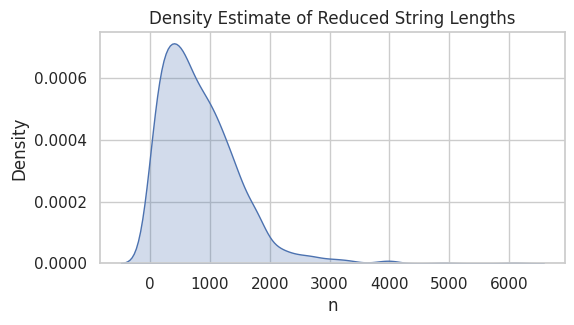

In [ ]:
M = pd.read_csv(os.path.join(wd, 'df_strings.csv'))
N = M[['n','s']].groupby(['n']).count().reset_index()
N.rename(columns={'s': 'count'}, inplace=True)

# Re-creating a Kernel Density Estimate (KDE) plot for the 'n' distribution
plt.figure(figsize=(6, 3))
sns.kdeplot(N['n'], bw_adjust=1, fill=True)
plt.title("Density Estimate of Reduced String Lengths")
plt.xlabel('n')
plt.ylabel('Density')
plt.show()

In [ ]:
# create *.sol files
import re

# extract atoms coordinates
def extract_coordinates(df):
    if len(df['x']) > 0:
        df['x'] = df['x'].apply(lambda x: eval(re.sub(" +", ",", re.sub(r"\[\s+","[", x))))
        x = np.array(df['x'].to_list())
        return x
    return None

for fn in tqdm(M['fn']):
    fn_segment = fn.replace('_binary.csv','.csv')
    fn_sol = fn.replace('_binary.csv','.sol')
    if os.path.exists(fn_sol):
        continue
    df_binary = pd.read_csv(fn)
    df = pd.read_csv(fn_segment)
    x = extract_coordinates(df)
    np.savetxt(fn_sol, x)


100%|██████████| 8499/8499 [08:54<00:00, 15.89it/s]


In [ ]:
from concurrent.futures import ThreadPoolExecutor

# Function to create and prune edges based on distance
def create_prune_edges(fn, dmax=5):
    Ep = {'i': [], 'j': [], 'dij': []}
    fn_nmr = fn.replace('.csv', '.nmr')

    # Skip if file already exists
    if os.path.exists(fn_nmr):
        return

    fn_sol = fn.replace('.csv', '.sol')
    x = np.loadtxt(fn_sol)

    for i in range(0, len(x)):
        xi = x[i]
        for j in range(i + 4, len(x)):
            xj = x[j]
            dij = np.linalg.norm(xi - xj)
            if dij < dmax:
                Ep['i'].append(i)
                Ep['j'].append(j)
                Ep['dij'].append(dij)

    Ep = pd.DataFrame(Ep)
    Ep.to_csv(fn_nmr, index=False)

# Determine the number of CPU cores
num_cores = os.cpu_count()

# Use number of cores - 1 for thread count
num_threads = num_cores - 1

# Using ThreadPoolExecutor to parallelize the function
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    list(tqdm(executor.map(create_prune_edges, M['fn']), total=len(M)))


100%|██████████| 8499/8499 [2:05:14<00:00,  1.13it/s]


In [ ]:
E = {'fn':[], 'df':[]}
for fn in tqdm(os.listdir(wd_segment)):
    if not fn.endswith('.nmr'):
        continue
    fn = os.path.join(wd_segment, fn)
    E['fn'].append(fn)
    E['df'].append(pd.read_csv(fn))

E = pd.DataFrame(E)

# remove empty dataframes from E
E = E[E['df'].apply(lambda x: len(x) > 0)].reset_index(drop=True)

100%|██████████| 25497/25497 [03:24<00:00, 124.80it/s]


len(D)=10661833


count    1.066183e+07
mean     2.812928e+01
std      9.196525e+01
min      4.000000e+00
25%      4.000000e+00
50%      6.000000e+00
75%      9.000000e+00
max      3.523000e+03
dtype: float64

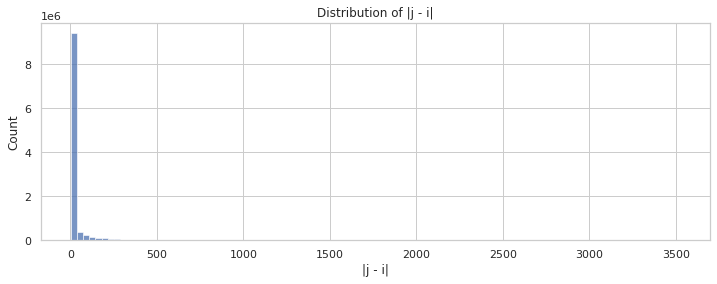

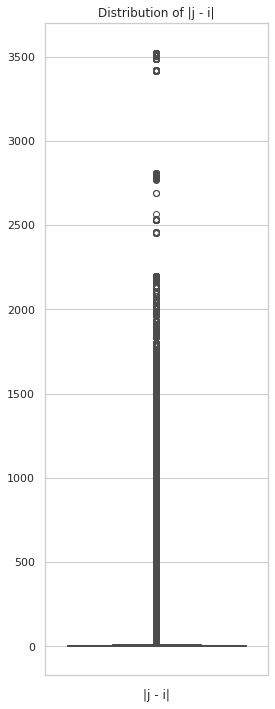

Text(0, 0.5, 'Count')

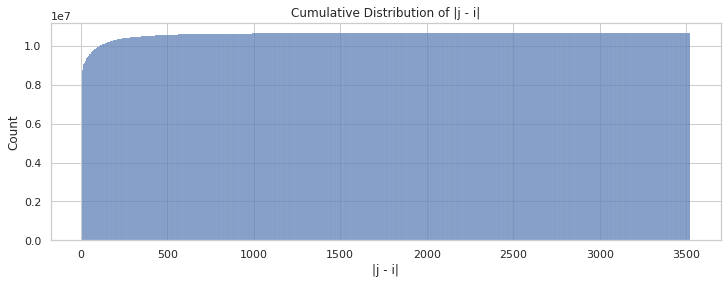

In [ ]:
# merge all dataframes on E['df']
D = pd.concat(E['df'].values, ignore_index=True)
print(f'len(D)={len(D)}')

v = D['j'] - D['i']

display(v.describe())

# using seaborn, create a histogram of the 'v' column
plt.figure(figsize=(12, 4))
sns.histplot(v, bins=100)
plt.title("Distribution of |j - i|")
plt.xlabel('|j - i|')
plt.ylabel('Count')
plt.show()

# using seaborn, create a boxplot of the 'v' column
plt.figure(figsize=(4, 12))
sns.boxplot(v)
plt.title("Distribution of |j - i|")
plt.xlabel('|j - i|')
plt.show()

# plot the cumulative distribution of the 'v' column
plt.figure(figsize=(12, 4))
sns.histplot(v, bins=1000, cumulative=True)
plt.title("Cumulative Distribution of |j - i|")
plt.xlabel('|j - i|')
plt.ylabel('Count')